# **Домашняя работа 4**



1.   Обучите CNN (самописная) на CIFAR-100.
2.   Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3.   *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.


Импорт библиотек

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 1 Обучите CNN (самописная) на CIFAR-100.

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

100%|██████████| 169001437/169001437 [00:03<00:00, 48920978.42it/s]


Extracting data/cifar-100-python.tar.gz to data/


In [3]:
dataset.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [5]:
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can',
'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud',
'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin',
'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo',
'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',
'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange',
'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain',
'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road',
'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper',
'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train','trout',
'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman','worm']

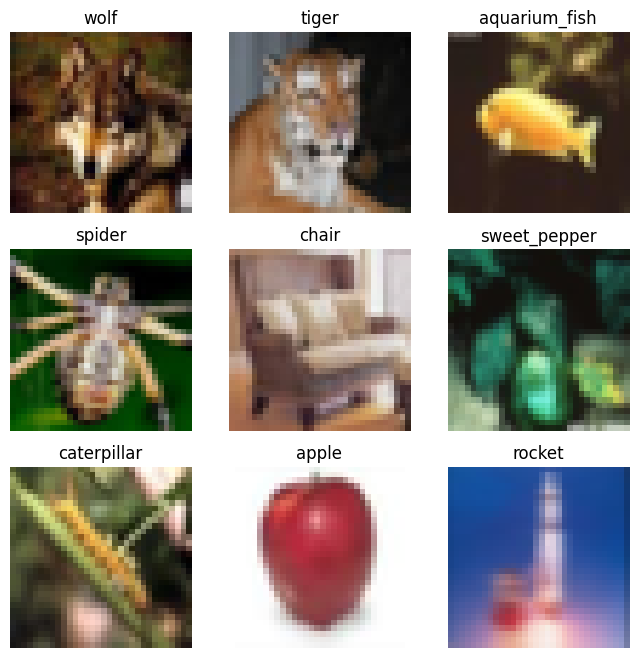

In [6]:
#просматриваем датасет
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [7]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [8]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [9]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

In [10]:
#разбиваем датасет
train_dataset, valid_dataset = train_valid_split(dataset)

#формируем экземпляры классов (тензор, класс)
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())
print('Количество экземплятор в тренировочном датасете: ', len(train_dataset))
print('Количество экземплятор в валидационном датасете: ', len(valid_dataset))

Количество экземплятор в тренировочном датасете:  47500
Количество экземплятор в валидационном датасете:  2500


In [11]:
#итераторы для работы с датасетом
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

Тензоры и Классы

один объект в train_loader -- это батч 128 из тензора размера (3,32,32), 128 меток классов

torch.Size([128, 3, 32, 32])
possum


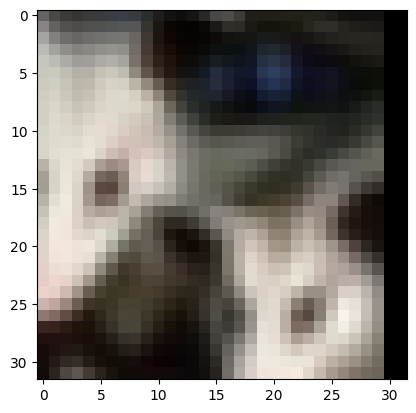

In [14]:
for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [15]:
train_features, train_labels = next(iter(train_loader))
print(train_features.shape, train_labels.shape)
train_features, train_labels

torch.Size([128, 3, 32, 32]) torch.Size([128])


(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.9765, 0.9804, 0.9804,  ..., 0.9529, 0.9412, 0.9333],
           [0.9569, 0.9647, 0.9725,  ..., 0.9137, 0.9020, 0.8980],
           ...,
           [0.4078, 0.4000, 0.3961,  ..., 0.3686, 0.3725, 0.3333],
           [0.4078, 0.3725, 0.3333,  ..., 0.2627, 0.2275, 0.2235],
           [0.3961, 0.3843, 0.3725,  ..., 0.1490, 0.1216, 0.1176]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9765, 0.9686],
           [0.9765, 0.9765, 0.9765,  ..., 0.9451, 0.9333, 0.9294],
           ...,
           [0.4667, 0.4549, 0.4431,  ..., 0.3922, 0.3922, 0.3529],
           [0.4706, 0.4353, 0.3882,  ..., 0.2784, 0.2431, 0.2353],
           [0.4588, 0.4510, 0.4314,  ..., 0.1647, 0.1373, 0.1294]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9882, 0.9804],
           [0.9922, 0.98

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
torch.manual_seed(10)

In [18]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60)
        self.conv_two = torch.nn.Conv2d(60, 120, 3)
        self.bn_three = torch.nn.BatchNorm2d(120)
        self.conv_three = torch.nn.Conv2d(120, 240, 3)
        self.bn_four = torch.nn.BatchNorm2d(240)
        self.fc1 = torch.nn.Linear(960, 400)
        self.out = torch.nn.Linear(400, 100)


    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        return self.out(x)


In [23]:
def train_eval_model(net, num_epochs, train_loader, valid_loader):
    for epoch in range(num_epochs):
        net.train()
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обучение
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            # выводим статистику о процессе обучения
            if i % 300 == 0:    # печатаем каждые 300 mini-batches
                net.eval()

                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}. ' \
                      f'Acc: {running_right / running_items:.3f}', end='. ')
                running_loss, running_items, running_right = 0.0, 0.0, 0.0

                test_running_right, test_running_total = 0.0, 0.0
                for i, data in enumerate(valid_loader):

                    test_outputs = net(data[0].to(device))
                    test_running_total += len(data[1])
                    test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

                print(f'Test acc: {test_running_right / test_running_total:.3f}')

    print('Обучение завершено!')

Инициализация модели

In [24]:
net = Net().to(device)
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(120, 240, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=960, out_features=400, bias=True)
  (out): Linear(in_features=400, out_features=100, bias=True)
)


In [25]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 60, 30, 30]           1,680
       BatchNorm2d-3           [-1, 60, 15, 15]             120
            Conv2d-4          [-1, 120, 13, 13]          64,920
       BatchNorm2d-5            [-1, 120, 6, 6]             240
            Conv2d-6            [-1, 240, 4, 4]         259,440
       BatchNorm2d-7            [-1, 240, 2, 2]             480
           Dropout-8                  [-1, 960]               0
            Linear-9                  [-1, 400]         384,400
          Dropout-10                  [-1, 400]               0
           Linear-11                  [-1, 100]          40,100
Total params: 751,386
Trainable params: 751,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

Компиляция модели

In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Обучение модели

In [28]:
num_epochs = 20
train_eval_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/20]. Step [1/372]. Loss: 0.032. Acc: 0.102. Test acc: 0.100
Epoch [1/20]. Step [301/372]. Loss: 0.029. Acc: 0.133. Test acc: 0.135
Epoch [2/20]. Step [1/372]. Loss: 0.029. Acc: 0.164. Test acc: 0.171
Epoch [2/20]. Step [301/372]. Loss: 0.025. Acc: 0.208. Test acc: 0.181
Epoch [3/20]. Step [1/372]. Loss: 0.026. Acc: 0.188. Test acc: 0.185
Epoch [3/20]. Step [301/372]. Loss: 0.024. Acc: 0.253. Test acc: 0.225
Epoch [4/20]. Step [1/372]. Loss: 0.025. Acc: 0.219. Test acc: 0.204
Epoch [4/20]. Step [301/372]. Loss: 0.022. Acc: 0.292. Test acc: 0.215
Epoch [5/20]. Step [1/372]. Loss: 0.024. Acc: 0.234. Test acc: 0.222
Epoch [5/20]. Step [301/372]. Loss: 0.021. Acc: 0.318. Test acc: 0.248
Epoch [6/20]. Step [1/372]. Loss: 0.022. Acc: 0.320. Test acc: 0.220
Epoch [6/20]. Step [301/372]. Loss: 0.020. Acc: 0.339. Test acc: 0.238
Epoch [7/20]. Step [1/372]. Loss: 0.024. Acc: 0.273. Test acc: 0.249
Epoch [7/20]. Step [301/372]. Loss: 0.020. Acc: 0.358. Test acc: 0.232
Epoch [8/20]. Step [

**Вывод**

Много классов мало данных для обучения

## 2 Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

Загрузка предобученной модели resnet50

In [29]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
# все обучаемые веса модели
for param in resnet50.parameters():
    print(param.requires_grad, end = ', ')

True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [31]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [32]:
# замораживаем все слои предобученной модели
set_parameter_requires_grad(resnet50, True)

In [33]:
# теперь все веса модели не обучаемы
for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [35]:
num_feature =resnet50.fc.in_features
num_feature

2048

In [36]:
#переопределяем последний слой сети
resnet50.fc = nn.Linear(num_feature, 100)

In [37]:
# все веса модели, кроме последнего, не обучаемы
for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [38]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
resnet50 = resnet50.to(device)

In [45]:
# преобразование признаков
trans_actions = transforms.Compose([transforms.Resize(124),
                                    transforms.RandomCrop(96, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(124),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

In [46]:
# разделение датасета на train и test
train_dataset, valid_dataset = train_valid_split(dataset)

# создание элементов класса датасета
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

# загрузчики датасетов
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [47]:
# список весов для обновления
params_to_update = []

# собираем рапаметры (веса), у которых param.requires_grad == True
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

params_to_update

[Parameter containing:
 tensor([[ 0.0136,  0.0482, -0.0562,  ..., -0.0167, -0.0012,  0.0201],
         [-0.0636,  0.0143, -0.0418,  ...,  0.0202, -0.0259, -0.0144],
         [-0.0143, -0.0163,  0.0340,  ..., -0.0205, -0.0093,  0.0028],
         ...,
         [ 0.0026, -0.0026, -0.0018,  ..., -0.0134, -0.0394, -0.0439],
         [-0.0414, -0.0027,  0.0659,  ..., -0.0297, -0.0037, -0.0160],
         [ 0.0424, -0.0049,  0.0026,  ...,  0.0517,  0.0461,  0.0083]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 5.6666e-03, -1.6111e-02,  1.2392e-03, -2.6472e-02,  1.7196e-02,
          1.1684e-02,  2.0459e-03, -5.2465e-04, -1.4703e-02,  2.5129e-03,
         -2.0651e-02, -2.2942e-02,  1.4112e-02, -4.7846e-03, -1.0876e-02,
         -5.9380e-03, -1.5613e-02, -8.7158e-03, -6.2479e-03, -6.6021e-03,
          4.3395e-03, -8.1165e-03,  1.2506e-02,  4.0315e-02,  6.1408e-03,
          6.4527e-04, -2.0954e-02, -1.7488e-02, -8.4067e-03,  8.3215e-03,
         -4.2317e-03, -

In [48]:
# компиляция модели
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [49]:
num_epochs = 10
net = resnet50
train_eval_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/10]. Step [1/372]. Loss: 0.022. Acc: 0.344. Test acc: 0.601
Epoch [1/10]. Step [301/372]. Loss: 0.013. Acc: 0.580. Test acc: 0.616
Epoch [2/10]. Step [1/372]. Loss: 0.019. Acc: 0.445. Test acc: 0.629
Epoch [2/10]. Step [301/372]. Loss: 0.011. Acc: 0.618. Test acc: 0.638
Epoch [3/10]. Step [1/372]. Loss: 0.017. Acc: 0.406. Test acc: 0.637
Epoch [3/10]. Step [301/372]. Loss: 0.010. Acc: 0.640. Test acc: 0.663
Epoch [4/10]. Step [1/372]. Loss: 0.016. Acc: 0.484. Test acc: 0.656
Epoch [4/10]. Step [301/372]. Loss: 0.010. Acc: 0.647. Test acc: 0.668
Epoch [5/10]. Step [1/372]. Loss: 0.015. Acc: 0.477. Test acc: 0.653
Epoch [5/10]. Step [301/372]. Loss: 0.010. Acc: 0.656. Test acc: 0.646
Epoch [6/10]. Step [1/372]. Loss: 0.018. Acc: 0.445. Test acc: 0.658
Epoch [6/10]. Step [301/372]. Loss: 0.010. Acc: 0.655. Test acc: 0.663
Epoch [7/10]. Step [1/372]. Loss: 0.014. Acc: 0.578. Test acc: 0.655
Epoch [7/10]. Step [301/372]. Loss: 0.009. Acc: 0.662. Test acc: 0.665
Epoch [8/10]. Step [

**Вывод**

Результаты не плохие но долговато обучается и ресурсо затрано